In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio

dtype = torch.float
device = torch.device("cuda:0")
device = torch.device("cpu")

weights = scio.loadmat("MATLABtest/volume_weights.mat")
pw1 = torch.tensor(weights["pw1"], dtype=torch.float32)
pb1 = torch.squeeze(torch.tensor(weights["pb1"], dtype=torch.float32))
pw2 = torch.tensor(weights["pw2"], dtype=torch.float32)
pb2 = torch.squeeze(torch.tensor(weights["pb2"], dtype=torch.float32))

In [27]:
model = torch.nn.Sequential(torch.nn.Linear(3,500), torch.nn.Sigmoid(), torch.nn.Linear(500,1))

model[0].weight = torch.nn.Parameter(pw1)
model[0].bias = torch.nn.Parameter(pb1)
model[2].weight = torch.nn.Parameter(pw2)
model[2].bias = torch.nn.Parameter(pb2)

In [28]:
class Poly1(torch.nn.Module):
    def __init__(self,dimension):
        super().__init__()
        self.dim = dimension

    def forward(self, x):
        # return poly(1, self.dim)
        return -torch.log(1 - (-torch.exp(x)))

class Qnet(torch.nn.Module):
    def __init__(self, dimension):
        super().__init__()
        with torch.no_grad():
            self.model = torch.nn.Sequential(torch.nn.Linear(dimension+1, 2**dimension, bias=False, dtype=torch.float32, device=device), Poly1(dimension), torch.nn.Linear(2**dimension, 1, bias=False, dtype=torch.float32,device=device))

        tpp = []
        for i in np.arange(0, 2**dimension, 1):
            tpp.append(list(np.binary_repr(i, width=dimension)))
        
        tpp = np.array(tpp).astype(float)
        S = torch.tensor(np.concatenate(((tpp == 0) * -1 + tpp, np.full((2**dimension, 1), -1)), axis=1), dtype=torch.float32, device=device)
        w3 = (-torch.prod(S, axis=1).T).reshape(1,S.size(0))

        self.model[0].weight = torch.nn.Parameter(S)
        self.model[2].weight = torch.nn.Parameter(w3)

    def forward(self, x):
        return self.model(x)

class Intergrator():
    def __init__(self,dimension):
        if (dimension != 1):
            print("activation function only works for 1 dimesnions for now")
        self.dim = dimension
        self.qnet = Qnet(dimension)

    def apply(self, W1, B1, W2, B2):
        y = torch.cat((W1, B1.reshape(W1.size(0),1)), axis=1)
        res = torch.div(self.qnet(y), torch.prod(W1, axis = 1).reshape(W1.size(0),1)) + 2**self.dim
        self.model = torch.nn.Linear(W2.size(1),1, dtype=torch.float32,device=device)
        self.model.weight = torch.nn.Parameter(W2)
        self.model.bias = torch.nn.Parameter(B2*(2**self.dim))

        return self.model(res.T)

tensor([[0.5651]])


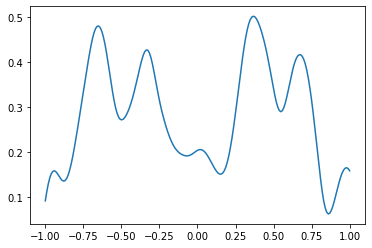

In [60]:
yslice = 0.5
zslice = 0.75

data = torch.tensor(np.concatenate((np.reshape(np.linspace(-1,1,200), (200,1)),np.reshape(np.linspace(yslice,yslice,200), (200,1)),np.reshape(np.linspace(zslice,zslice,200), (200,1))), axis=1), dtype=torch.float32)
# Maginalising the Z and Y dimensions
intDim = pw1[:,:1] # get the x weights 
slicedDims = pw1[:, 1:] # get the z and y weights

constants = torch.tensor([yslice,zslice],dtype=torch.float32)

newb1 = pb1 + slicedDims.matmul(constants) # update bais

with torch.no_grad():
    res = (model(data).detach().numpy() +1)/2
    print((Intergrator(1).apply(intDim, newb1, pw2, pb2) + 2)/2)

plt.plot(np.reshape(np.linspace(-1,1,200), (200,1)), res)
